In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from k2 import K2Processor
from evaluation import extract_params, spawn_model

In [3]:
import utils
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import networkx as nx
import os

In [18]:
test_df = pd.read_csv('../data/results/K2_test_results.csv', index_col=0)

In [19]:
filt = test_df[(test_df.encoder == 'COLLAPSE') & (test_df.metric == 'precision') & (test_df.regime == 'class-1')].sort_values('value', ascending=False)
filt.head(20)

,encoder,model,threshold,datum_id,regime,metric,value
1367,COLLAPSE,k15_r1_cutoff8.00_alpha0.500_tau4.00_lamnan.model,0.9,4h3sA.pkl,class-1,precision,1.0
1226,COLLAPSE,k15_r1_cutoff8.00_alpha0.500_tau4.00_lamnan.model,0.9,4m0wA.pkl,class-1,precision,1.0
1233,COLLAPSE,k15_r1_cutoff8.00_alpha0.500_tau4.00_lamnan.model,0.9,4m3pA.pkl,class-1,precision,1.0
1262,COLLAPSE,k15_r1_cutoff8.00_alpha0.500_tau4.00_lamnan.model,0.9,3vhtB.pkl,class-1,precision,1.0
164,COLLAPSE,k15_r1_cutoff8.00_alpha0.500_tau4.00_lamnan.model,0.9,3q1dA.pkl,class-1,precision,1.0
182,COLLAPSE,k15_r1_cutoff8.00_alpha0.500_tau4.00_lamnan.model,0.9,4rvnB.pkl,class-1,precision,1.0
1161,COLLAPSE,k15_r1_cutoff8.00_alpha0.500_tau4.00_lamnan.model,0.9,4ld2A.pkl,class-1,precision,1.0
1201,COLLAPSE,k15_r1_cutoff8.00_alpha0.500_tau4.00_lamnan.model,0.9,1xjsA.pkl,class-1,precision,1.0
1057,COLLAPSE,k15_r1_cutoff8.00_alpha0.500_tau4.00_lamnan.model,0.9,2naaA.pkl,class-1,precision,1.0
1090,COLLAPSE,k15_r1_cutoff8.00_alpha0.500_tau4.00_lamnan.model,0.9,2orwA.pkl,class-1,precision,1.0


<Axes: >

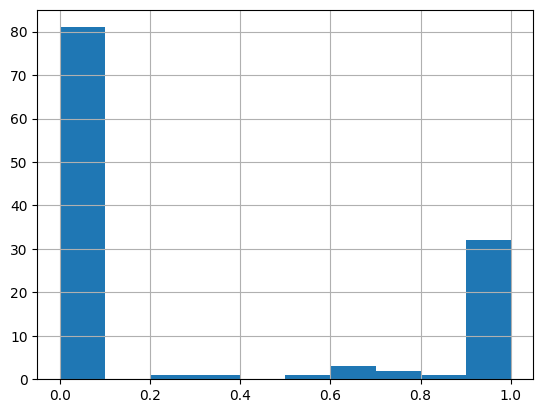

In [20]:
filt.value.hist()

In [21]:
high_precision = filt[filt.value > 0.5]

In [22]:
metal = 'ZN'
encoder = 'COLLAPSE'
model_str = filt.model.iloc[0]
k,r,cutoff,alpha,tau,lam = extract_params(model_str)

processor_cache_dir = f"../data/{encoder}_{metal}_gridsearch_results_2/{encoder}-fitted_k2_processors"
model_cache_dir = f"../data/{encoder}_{metal}_gridsearch_results_2/{encoder}-fitted_k2_models"
# G_test_dir = f"../data/{encoder}_{metal}_cutoff_test_graphs_2"
# G_train_dir = f"../data/{encoder}_{metal}_cutoff_train_graphs_2"
G_dir = f"../data/{encoder}_{metal}_{cutoff}_test_graphs"

# model_str = "k25_r4_cutoff6.00_alphanan_taunan_lam0.50.model" #using the best r>0 model for viz


In [23]:
def create_visualizations(G_id, model_str, processor_cache_dir, model_cache_dir, G_dir, datatype="protein", vis='kernel'):
    k,r,cutoff,alpha,tau,lam = extract_params(model_str)
    processor_name = "k%d_cutoff%.2f.processor" % (k, cutoff)
    G_dir = G_dir.replace('cutoff', '%.1f'%cutoff)

    proc = utils.deserialize_model(os.path.join(processor_cache_dir, processor_name))
    model = utils.deserialize_model(os.path.join(model_cache_dir, model_str))

    G_path = G_dir + "/" + G_id + ".pkl"
    G = utils.deserialize(G_path)
    sprite = utils.construct_sprite(G, proc)
    P = model.prospect(G)
    print(utils.linearize_graph(P))
    # print(utils.linearize_graph(sprite))

    if vis=='kernel':
        print('visualizing motif graph...')
        kernel_map = model.visualize_motif_graph(G)
    else:
        if datatype=='protein':
            if vis =='sprite':
                print('visualizing sprite...')
                sprite_viz = utils.visualize_protein_sprite(sprite)
                return sprite_viz
            elif vis=='prospect':
                print('visualizing prospect map...')
                prospect_map = utils.visualize_protein_sprite(P, prospect_flag=True)
                return prospect_map
            else:
                print('visualizing ground truth...')
                gt = utils.visualize_protein_sprite(utils.set_graph_emb(G, 'gt'), gt_flag=True)
                return gt

        elif datatype=="image":
            sprite_map = utils.convert_graph2arr(sprite)
            sprite_viz = utils.visualize_quantizedZ(sprite_map)
            prospect_map = model.visualize_prospect_map(P)
            gt = model.visualize_prospect_map(P, gt_flag=True)

        # return kernel_map, sprite_viz, prospect_map, gt

No G provided, showing model-wide kernel hash-graph
Displaying motif graph with log2 scaling


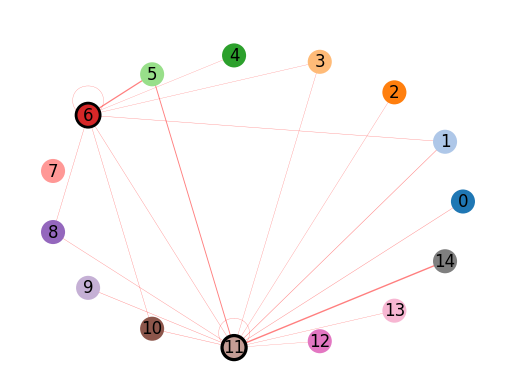

In [25]:
model = utils.deserialize_model(os.path.join(model_cache_dir, model_str))
model.visualize_motif_graph(labels=True)

No G provided, showing model-wide kernel hash-graph
Displaying motif graph with log2 scaling


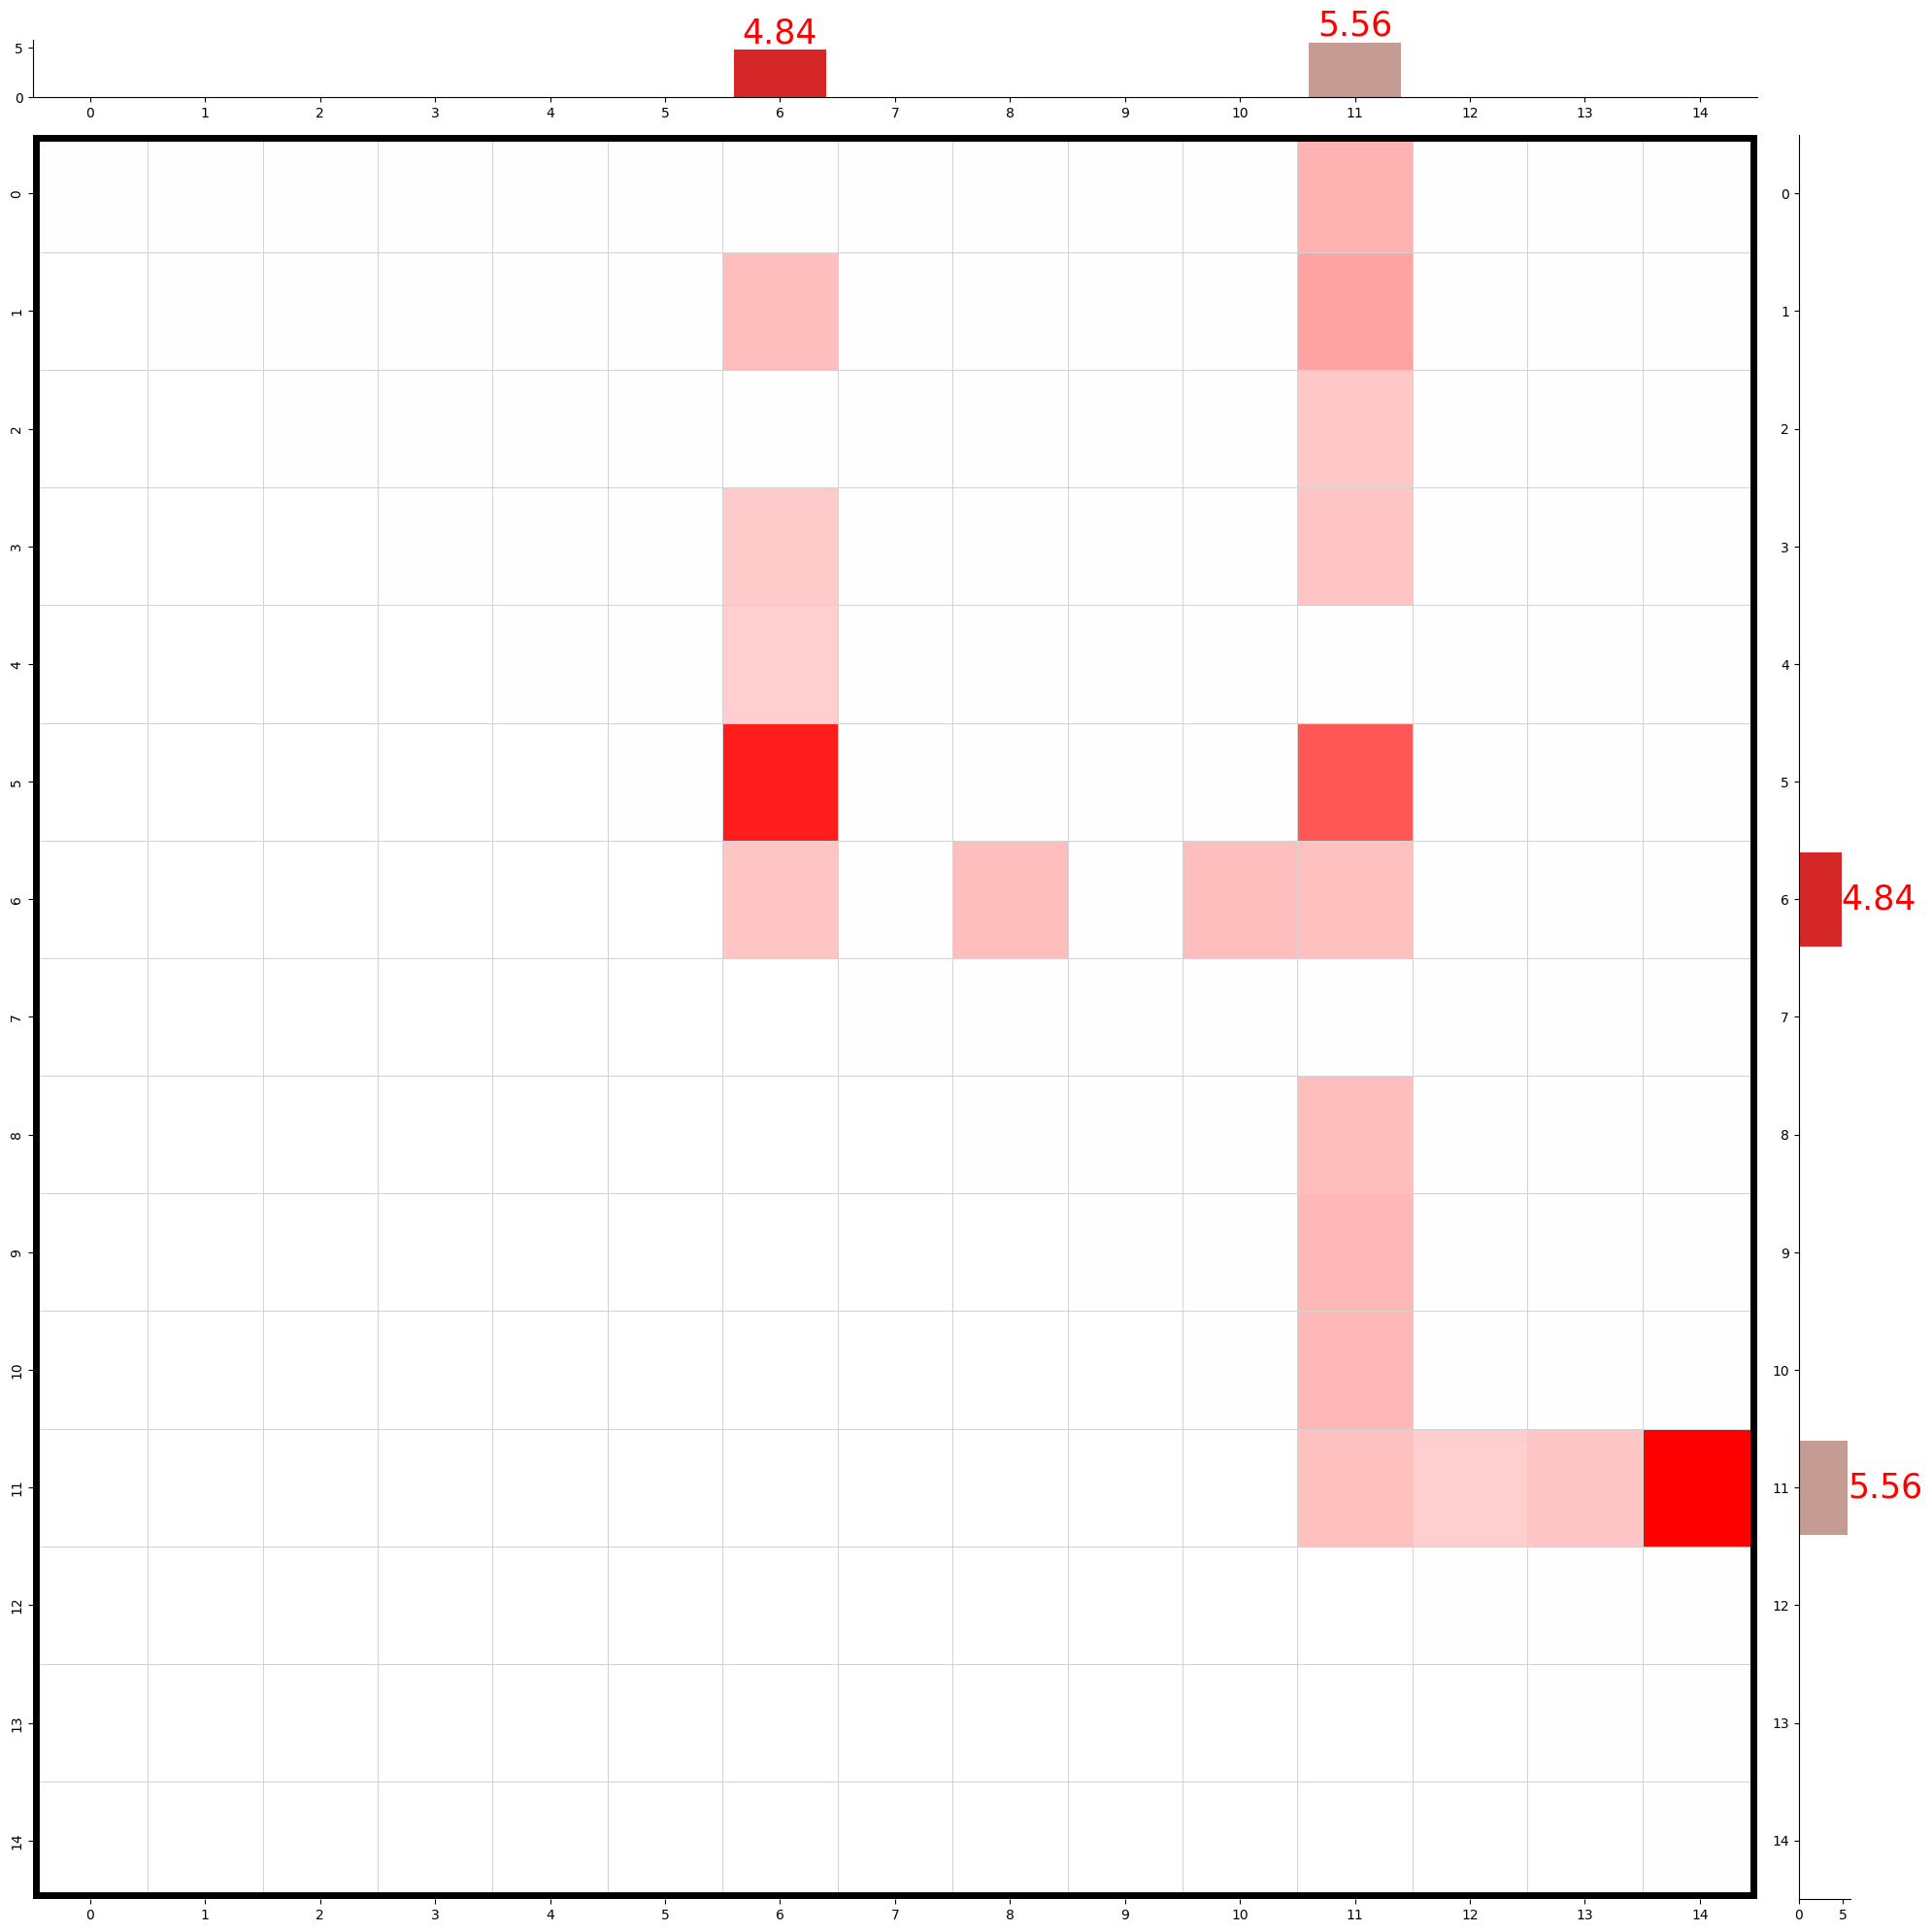

In [27]:
model.visualize_motif_graph(style="matrix", labels=True)

In [28]:
def create_visualizations(G_id, model_str, processor_cache_dir, model_cache_dir, G_dir, datatype="protein", gt_path=None):
    if datatype == "protein":
        k,r,cutoff,alpha,tau,lam = extract_params(model_str)
        processor_name = "k%d_cutoff%.2f.processor" % (k, cutoff)
        G_dir = G_dir.replace('cutoff', '%.1f'%cutoff)
    elif datatype in ['text', "image"]:
        k,r,alpha,tau,lam = extract_params(model_str)
        processor_name = "k%d.processor" % (k)

    proc = utils.deserialize_model(os.path.join(processor_cache_dir, processor_name))
    model = utils.deserialize_model(os.path.join(model_cache_dir, model_str))
    model.visualize_motif_graph(labels=True) # sets color
    color_assign = model.color_assignments

    if datatype == "protein":
        G_path = G_dir + "/" + G_id + ".pkl"
    elif datatype in ["text","image"]:
        G_path = G_dir + "/" + G_id 
    G = utils.deserialize(G_path)
    sprite = utils.construct_sprite(G, proc)
    P = model.prospect(G)
    print('visualizing motif graph...')
    # kernel_map = model.visualize_motif_graph(G)
    kernel_map = model.visualize_motif_graph(G,style="graph",labels=True)
    kernel_map2 = model.visualize_motif_graph(G,style="matrix",labels=True)
    
    if datatype=='protein':
        print('visualizing sprite...')
        sprite_viz = utils.visualize_protein_sprite(sprite)
        print('visualizing prospect map...')
        prospect_map = utils.visualize_protein_sprite(P, prospect_flag=True)
        print('visualizing ground truth...')
        gt = utils.visualize_protein_sprite(utils.set_graph_emb(G, 'gt'), gt_flag=True)
    elif datatype in ['text', "image"]:
        sprite_map = utils.convert_graph2arr(sprite)
        sprite_viz = utils.visualize_quantizedZ(sprite_map, colors=color_assign)
        sprite_graph = utils.visualize_sprite(sprite, color_assign=color_assign)
        prospect_map = model.visualize_prospect_map(P)
        if datatype == "image":
            gt = utils.deserialize(os.path.join(gt_path, G_id + "-graph"))
        elif datatype == "text":
            G_id = G_id.split("_graph")[0] + "_gt.obj"
            gt = utils.deserialize(os.path.join(gt_path, G_id))
        gt_arr = utils.convert_GTgraph2arr(gt)
        utils.visualize_GTmap(gt_arr, sprite_map)

    return kernel_map, sprite_viz, prospect_map, gt

No G provided, showing model-wide kernel hash-graph
Displaying motif graph with log2 scaling
visualizing motif graph...
Displaying motif graph with log10 scaling
Displaying motif graph with log10 scaling


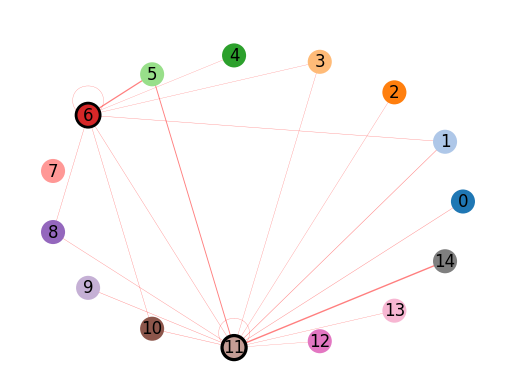

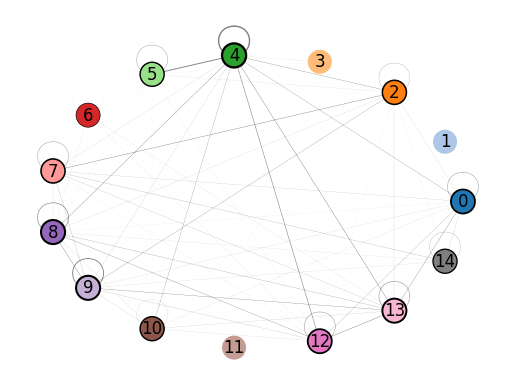

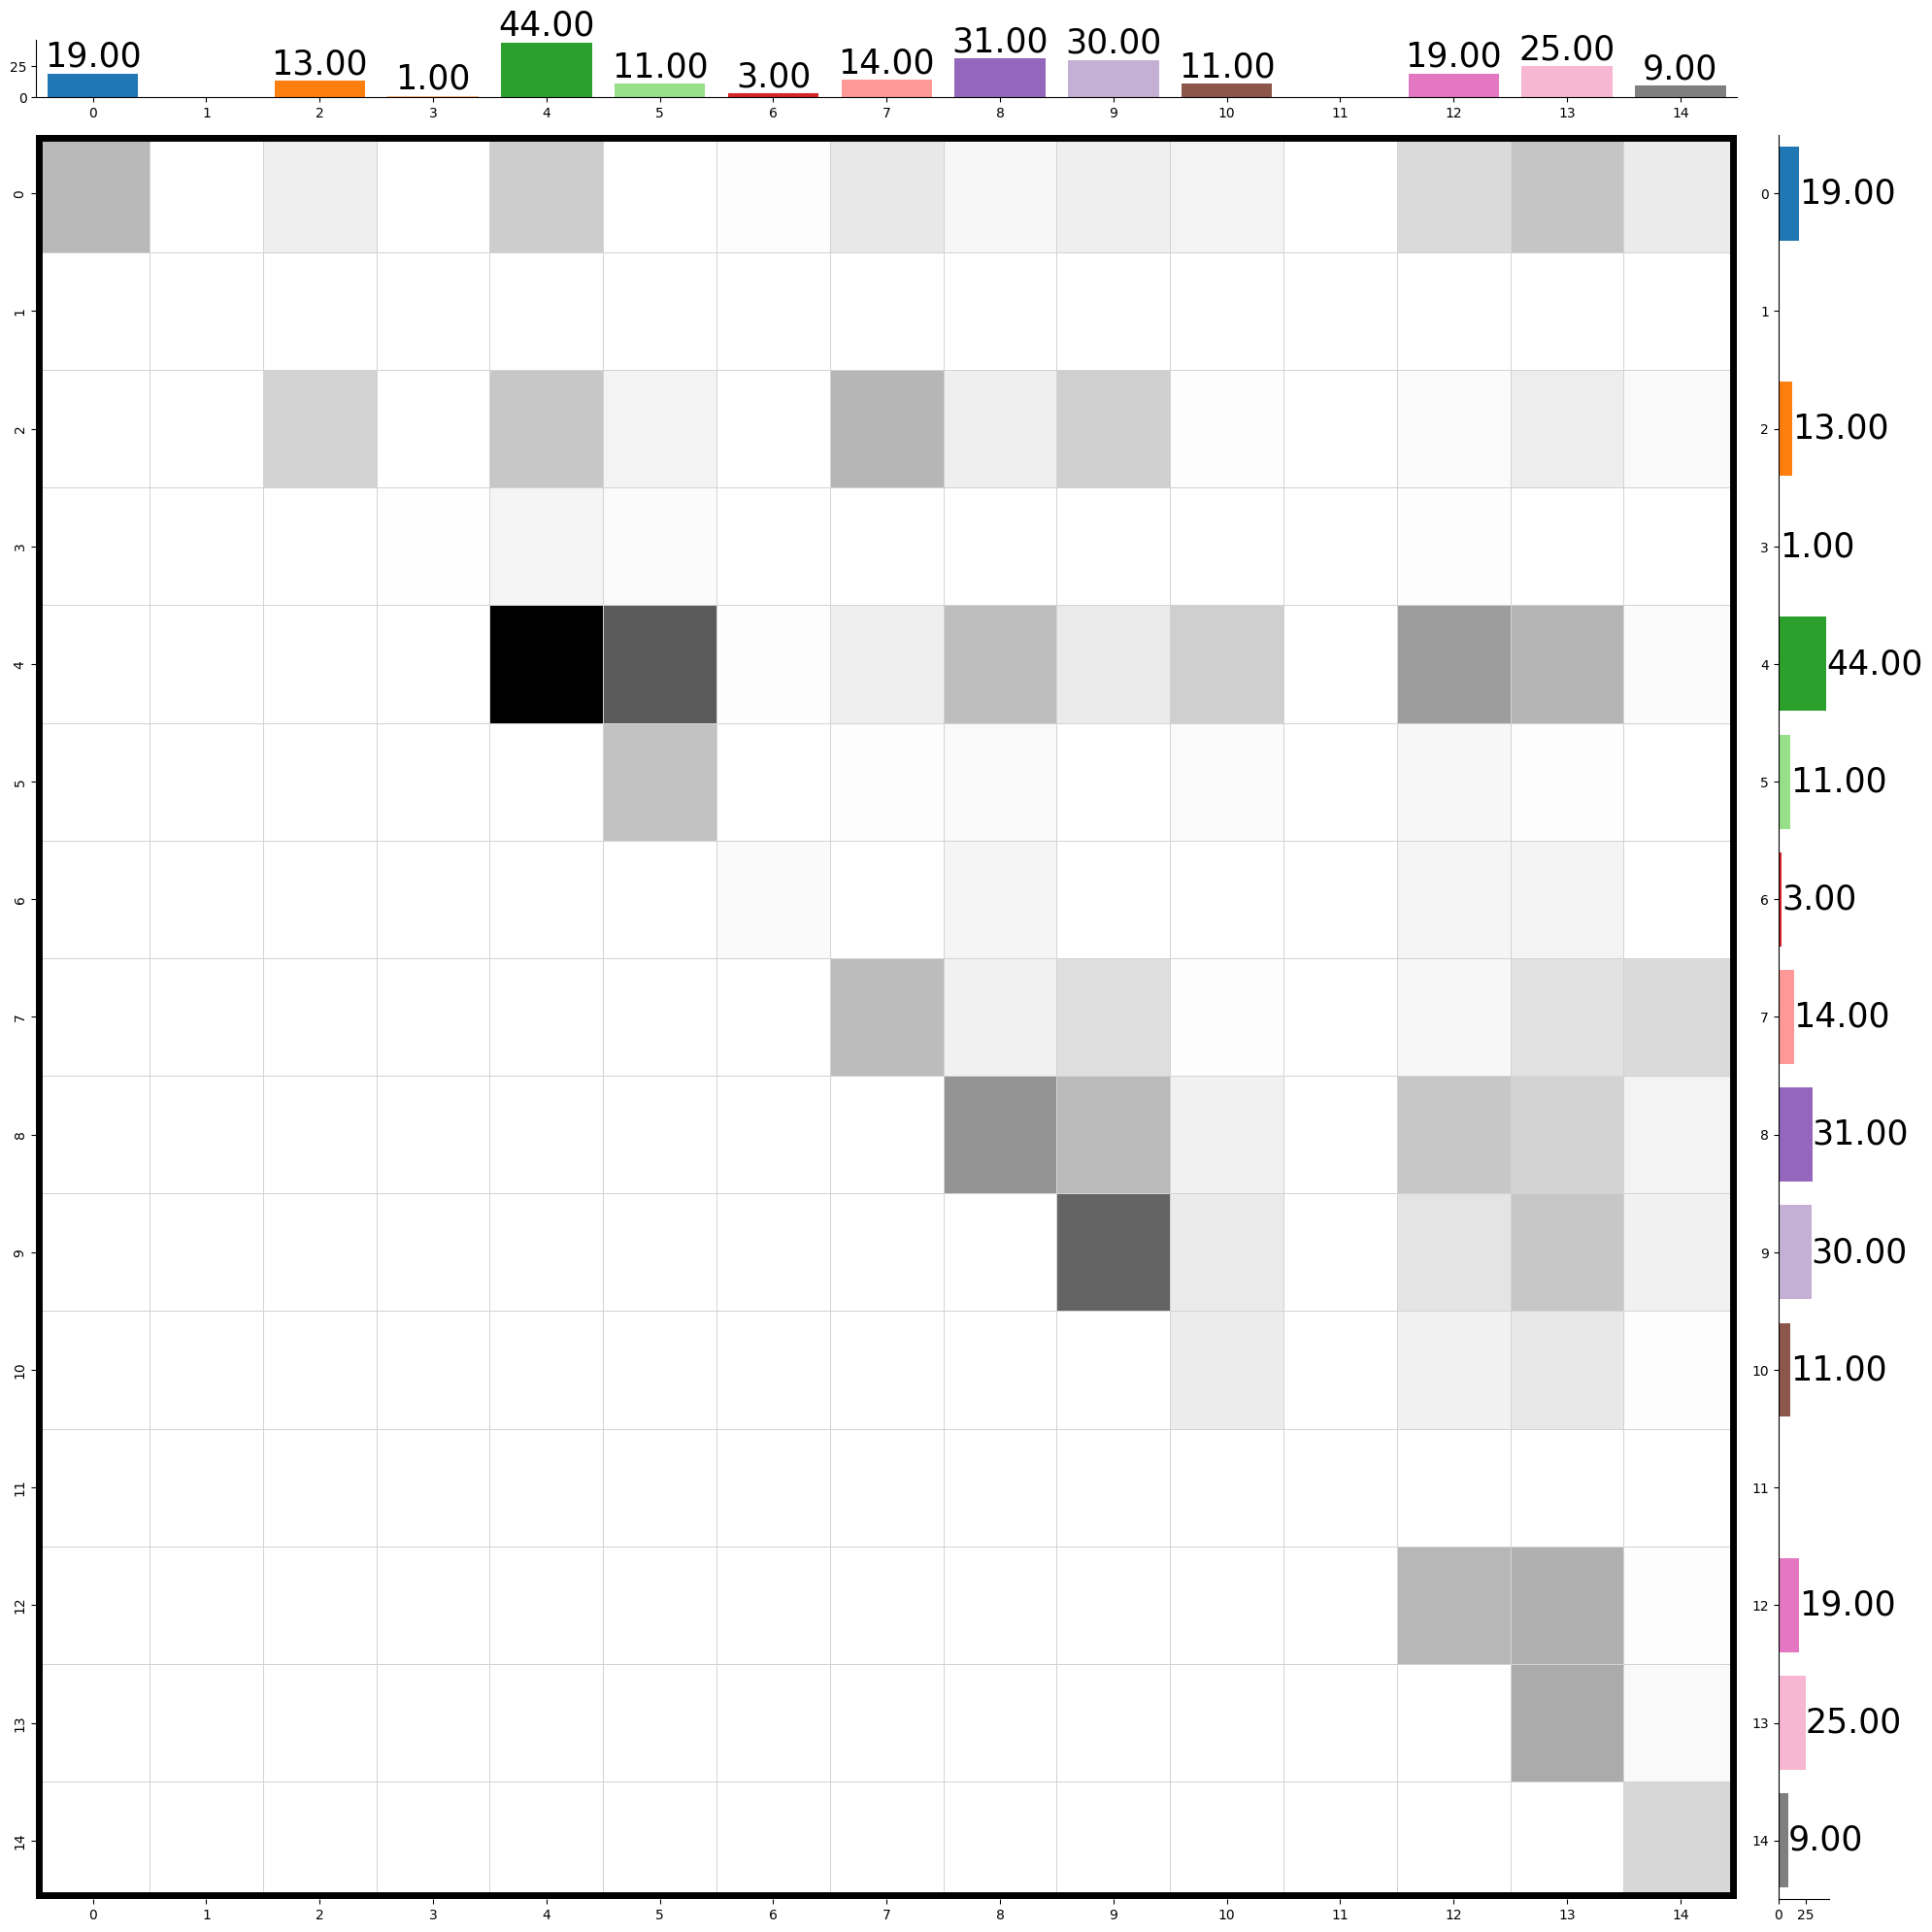

visualizing sprite...


AttributeError: module 'nglview.color' has no attribute '_ColorScheme'

In [30]:
G_id = "2eg4A"
create_visualizations(G_id, model_str, processor_cache_dir, model_cache_dir, G_dir, datatype="protein")

In [56]:
v = create_visualizations(G_id, model_str, processor_cache_dir, model_cache_dir, G_dir, datatype="protein", vis='sprite')
v

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
[14  7  2 14  2  5  2  5  5  5  5  5  2  0  9  2 13 12 12 12 12 12  0  0
  9  9 13 11 11  1 13 11 11  1 13 11  1  1 13 11  1  1 11 12 14  4  2  2
  5  5  2  2  2  2  2  2  2 14  7  7  4  7 14  7 14  0  7  0  0  9  9 13
 13 11 11  5 11 11 13 13 11 11 11 13 12 12 12  7  7  2  2  2  5  5  5  5
  2  2  2  7  4  7  7  7  7  4  4  3  4  4  4  4  4 14  4  0  0  9 14  4
  2  2  5  5  2  2 14  7 

NGLWidget()

In [54]:
v = create_visualizations(G_id, model_str, processor_cache_dir, model_cache_dir, G_dir, datatype="protein", vis='prospect')
v

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
visualizing prospect map...


NGLWidget()

In [49]:
create_visualizations(G_id, model_str, processor_cache_dir, model_cache_dir, G_dir, datatype="protein", vis='gt')

visualizing ground truth...


NGLWidget()

visualizing motif graph...
Displaying motif graph with log10 scaling


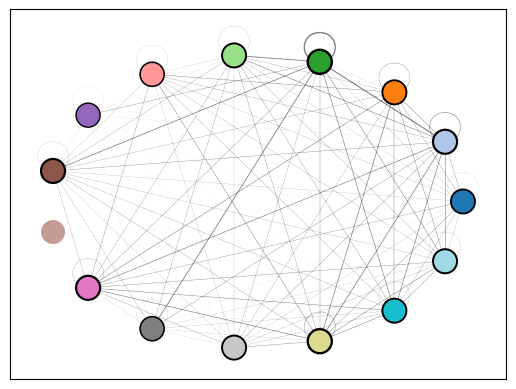

In [17]:
k,r,cutoff,alpha,tau,lam = extract_params(model_str)
processor_name = "k%d_cutoff%.2f.processor" % (k, cutoff)
G_dir = G_dir.replace('cutoff', '%.1f'%cutoff)

proc = utils.deserialize_model(os.path.join(processor_cache_dir, processor_name))
model = utils.deserialize_model(os.path.join(model_cache_dir, model_str))

G_path = G_dir + "/" + G_id + ".pkl"
G = utils.deserialize(G_path)
sprite = utils.construct_sprite(G, proc)
P = model.prospect(G)
print('visualizing motif graph...')
kernel_map = model.visualize_motif_graph(G)

# if datatype=='protein':
#     print('visualizing sprite...')
#     sprite_viz = utils.visualize_protein_sprite(sprite)
#     sprite_viz.show()
#     print('visualizing prospect map...')
#     prospect_map = utils.visualize_protein_sprite(P, prospect_flag=True)
#     prospect_map.show()
#     print('visualizing ground truth...')
#     gt = utils.visualize_protein_sprite(utils.set_graph_emb(G, 'gt'), gt_flag=True)
#     gt.show()
# elif datatype=="image":
#     sprite_map = utils.convert_graph2arr(sprite)
#     sprite_viz = utils.visualize_quantizedZ(sprite_map)
#     prospect_map = model.visualize_prospect_map(P)
#     gt = model.visualize_prospect_map(P, gt_flag=True)

In [ ]:
utils.visualize_protein_sprite(sprite)

In [ ]:
utils.visualize_protein_sprite(P, prospect_flag=True)

In [ ]:
utils.visualize_protein_sprite(utils.set_graph_emb(G, 'gt'), gt_flag=True)

In [126]:
import time
def save_image(view, fname):
    img = view.render_image()
    
    while not img.value:
        time.sleep(0.1)
    
    with open(f"{fname}.png", "wb") as f:
        f.write(img.value)

In [ ]:
save_image(sprite_viz, f'{G_id}_sprite')

In [161]:
sprite_viz

NGLWidget()

In [162]:
prospect_map

NGLWidget()

In [163]:
# show_residues_around(gt, "ZN")
# gt.center("ZN")
gt

NGLWidget()

In [122]:
sprite_viz.render_image(trim=True, factor=2)

Image(value=b'', width='99%')

In [10]:
from tqdm import tqdm
def linearized_kernel(G_id, model_str, processor_cache_dir, model_cache_dir, G_dir, datatype="protein"):
    k,r,cutoff,alpha,tau,lam = extract_params(model_str)
    processor_name = "k%d_cutoff%.2f.processor" % (k, cutoff)
    G_dir = G_dir.replace('cutoff', '%.1f'%cutoff)

    proc = utils.deserialize_model(os.path.join(processor_cache_dir, processor_name))
    model = utils.deserialize_model(os.path.join(model_cache_dir, model_str))

    G_path = G_dir + "/" + G_id + ".pkl"
    G = utils.deserialize(G_path)
    sprite = utils.construct_sprite(G, proc)
    P = model.prospect(G)

    kernel_map = model.motif_graph_weight(sprite)
    n_weights = list(nx.get_node_attributes(kernel_map, 'n_weight').values())
    e_weights = list(nx.get_edge_attributes(kernel_map, 'e_weight').values())
    lin_kernel = n_weights + e_weights

    return lin_kernel

In [11]:
kernel_arr = []
labels = []
for g_path in tqdm(high_precision.datum_id):
    G_id = g_path.strip('.pkl')
    kernel = linearized_kernel(G_id, model_str, processor_cache_dir, model_cache_dir, G_dir, datatype="protein")
    kernel_arr.append(kernel)
    labels.append(G_id)
kernel_arr = np.array(kernel_arr)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [01:18<00:00,  2.02s/it]


In [12]:
kernel_arr

array([[  6.,   0.,   0., ...,   0.,   4.,   0.],
       [ 33.,   7.,  11., ...,  14.,  35., 181.],
       [  0.,   0.,   0., ...,   0.,   1.,   0.],
       ...,
       [  9.,   0.,  16., ...,   2.,   7.,  39.],
       [ 24.,  14.,  32., ...,  32., 124.,  25.],
       [  3.,   0.,   0., ...,   0.,   2.,   0.]])

In [31]:
import seaborn as sns
def setup_figure(width=6, height=3):
    fig, ax = plt.subplots(figsize=(width,height))
    sns.set(style='white')
    sns.set_context('paper')
    return fig, ax
pal = sns.color_palette('tab20')

In [35]:
cmap = {2: 'gray', 3: 'orange', 4: 'red'}
colors = [cmap[x] for x in [3, 3, 2, 3, 3, 3, 3, 3, 3, 4, 4, 2, 4, 4, 3, 2, 3, 3, 4, 2, 4, 2, 3, 2, 4, 4, 4, 4, 4, 4, 3, 3, 4, 4, 4, 3, 3, 4, 4]]

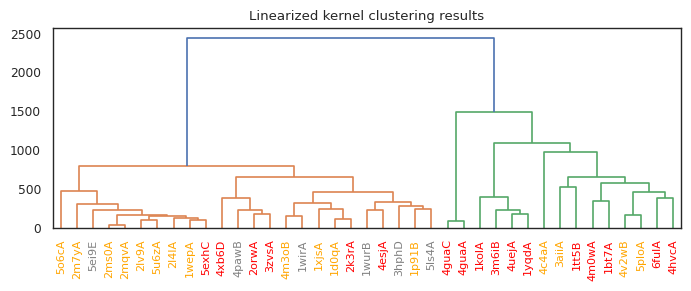

In [38]:
from scipy.cluster.hierarchy import dendrogram, linkage

fig, ax = setup_figure(7,3)
linkage_data = linkage(kernel_arr, method='ward', metric='euclidean')
dendrogram(linkage_data, labels=labels)
plt.title('Linearized kernel clustering results')
plt.xticks(rotation=90, ha='center')
[t.set_color(i) for (i,t) in
 zip(colors,ax.xaxis.get_ticklabels())]
plt.tight_layout()
plt.savefig("../data/figures/zn_clusters.png", dpi=300, format='png')
plt.show()

In [ ]:
['5o6cA', '2m7yA', '5ei9E', '2ms0A', ]
[3, 3, 2, 3, 3, 3, 3, 3, 3, 4, 4, 2, 4, 4, 3, 2, 3, 3, 4, 2, 4, 2, 3, 2, 4, 4, 4, 4, 4, 4, 3, 3, 4, 4, 4, 3, 3, 4, 4]